In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

from Engine.GlobalClock import GlobalClock, Agent
from Engine.State import State
from Engine.Aircraft import AircraftType
from Engine.FlightPlan import FlightPlan
from Engine.MultiRotorController import MR_Controller
from Engine.Wind import WindField
from Engine.Sensors import NavUpdate, GPSPosNavUpdate
from Engine.DragModel import DragModel
from Engine.TrackingSystem import *

import time

from scipy import interpolate

# 
def calc_diameter(mass, option='random'):
    """Data for this function obtained from log-log plot of popular DJI quadrotors.
    For the various options: 
    random (default) --> randomizes calculated prop diameter based on a random multiplier
    fixed extrapolation --> disables the randomization ^^
    minimum --> uses a fixed multiplier of 0.8
    maximum --> uses a fixed multiplier of 1.2
    """
    if option == 'random':
        diameter = round(np.random.uniform(0.8, 1.2) * np.exp((0.3878 * np.log(mass) + 2.1387)), 1)
    if option == 'fixed extrapolation':
        diameter = round(np.exp((0.3878 * np.log(mass) + 2.1387)), 1)
    if option == 'minimum':
        diameter = round(0.8 * np.exp((0.3878 * np.log(mass) + 2.1387)), 1)
    if option == 'maximum':
        diameter = round(1.2 * np.exp((0.3878 * np.log(mass) + 2.1387)), 1)
    return diameter

# NOTE: Controller struggles with high drag situations and sudden direction changes. Due to this limitation,
# overall drag figures have been slightly decreased from those estimated in (Dai W., Quek Z.H., Low K.H., 2022)
# 
# E.g. mass = 0.25 kg, prop_diam = calc_diameter(0.25, option='maximum')
# And the following WPT list: 
#
# AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([100,0,0]), np.array([300,0,0]), np.array([500,0,0])]
# AC1_Wpt_Start_Time = [0, 40, 80, 120]
# AC1_Wpt_End_List = [np.array([100,0,0]), np.array([300,0,0]), np.array([500,0,0]), np.array([100,0,0])]
# AC1_Wpt_End_Time = [40, 80, 120, 160]
# AC1_Mode_List = ['Direct_P2P', 'Direct_P2P', 'Direct_P2P', 'Direct_P2P']
# AC1_Duration_List = [40, 40, 40, 40]
# AC1_Leg_Spd = [20, 20, 20, 20]

In [2]:
print('For mass = 1.2 kg, fixed extrapolation: ', calc_diameter(1.2, option='fixed extrapolation'))
print('For mass = 0.25 kg, fixed extrapolation: ', calc_diameter(0.25, option='fixed extrapolation'))
print('For mass = 0.25 kg, minimum: ', calc_diameter(0.25, option='minimum'))
print('For mass = 0.25 kg, maximum: ', calc_diameter(0.25, option='maximum'))
print('For mass = 25 kg, fixed extrapolation: ', calc_diameter(25, option='fixed extrapolation'))
print('For mass = 25 kg, minimum: ', calc_diameter(25, option='minimum'))
print('For mass = 25 kg, maximum: ', calc_diameter(25, option='maximum'))

For mass = 1.2 kg, fixed extrapolation:  9.1
For mass = 0.25 kg, fixed extrapolation:  5.0
For mass = 0.25 kg, minimum:  4.0
For mass = 0.25 kg, maximum:  6.0
For mass = 25 kg, fixed extrapolation:  29.6
For mass = 25 kg, minimum:  23.7
For mass = 25 kg, maximum:  35.5


In [3]:
# Initialize GlobalClock to synchronize all agent behaviours
clock = GlobalClock(update_rate=120, stop=1000, start=0)
# clock = GlobalClock(update_rate=120, stop=200, start=0)

AC1_AircraftType = AircraftType(mass=0.25, prop_diameter=calc_diameter(0.25, option='maximum'), max_cruise_spd=20)
# AC1_AircraftType = AircraftType(mass=25, prop_diameter=calc_diameter(25, option='fixed extrapolation'), max_cruise_spd=40)

#---------------------- HOVER --> DIRECT_P2P TEST FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([0,0,0]), np.array([100,100,100]), np.array([0,0,0])]
# AC1_Wpt_Start_Time = [0, 10, 28, 37]
# AC1_Wpt_End_List = [np.array([0,0,0]), np.array([100,100,100]), np.array([0,0,0]), np.array([50,50,0])]
# AC1_Wpt_End_Time = [10, 28, 37, 51]
# AC1_Mode_List = ['Hover', 'Direct_P2P', 'Direct_P2P', 'Direct_P2P']
# AC1_Duration_List = [10, 18, 9, 14]
# AC1_Leg_Spd = [0, 10, 20, 5]
# AC1_Climb_rate = [0, 0, 0, 0]


#---------------------- DIRECT_P2P --> HOVER TEST FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([100,0,0])]
# AC1_Wpt_Start_Time = [0, 25]
# AC1_Wpt_End_List = [np.array([100,0,0]), np.array([100,0,0])]
# AC1_Wpt_End_Time = [25, 125]
# AC1_Mode_List = ['Direct_P2P', 'Hover']
# AC1_Duration_List = [25, 100]
# AC1_Leg_Spd = [20, 0]
# AC1_Climb_rate = [0, 0]


#---------------------- DIRECT_P2P TEST FLIGHT PLAN -------------------------
AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([0,400,400]), np.array([400,400,400]), np.array([400,0,100])]
AC1_Wpt_Start_Time = [0, 40, 80, 120]
AC1_Wpt_End_List = [np.array([0,400,400]), np.array([400,400,400]), np.array([400,0,100]), np.array([0,0,100])]
AC1_Wpt_End_Time = [40, 80, 120, 160]
AC1_Mode_List = ['Direct_P2P', 'Direct_P2P', 'Direct_P2P', 'Direct_P2P']
AC1_Duration_List = [40, 40, 40, 40]
AC1_Leg_Spd = [10, 10, 10, 10]
AC1_Climb_rate = [0, 0, 0, 0]


#---------------------- HOVER TEST FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([10,0,10]), np.array([10,0,10])]
# AC1_Wpt_Start_Time = [0, 100]
# AC1_Wpt_End_List = [np.array([10,0,10]), np.array([10,0,10])]
# AC1_Wpt_End_Time = [100, 200]
# AC1_Mode_List = ['Hover', 'Hover']
# AC1_Duration_List = [100, 100]
# AC1_Leg_Spd = [0, 0]
# AC1_Climb_rate = [0, 0]


#---------------------- SPEED TEST FLIGHT PLAN -------------------------
# MAX GRDSPD --> APPROX 20 m/s
# MAX WINDSPD --> APPROX 5 m/s
# MAX AIRSPD --> APPROX 25 m/s

# AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([500,0,0]), np.array([1000,0,0]), np.array([1500,0,0])]
# AC1_Wpt_Start_Time = [0, 40, 80, 120]
# AC1_Wpt_End_List = [np.array([500,0,0]), np.array([1000,0,0]), np.array([1500,0,0]), np.array([300,0,0])]
# AC1_Wpt_End_Time = [40, 80, 120, 160]
# AC1_Mode_List = ['Direct_P2P', 'Direct_P2P', 'Direct_P2P', 'Direct_P2P']
# AC1_Duration_List = [40, 40, 40, 40]
# AC1_Leg_Spd = [10, 15, 20, 15]
# # AC1_Leg_Spd = [15, 20, 25, 30]
# AC1_Climb_rate = [0, 0, 0, 0]


#---------------------- CLIMB TEST FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([0,0,-200])]
# AC1_Wpt_Start_Time = [0, 100]
# AC1_Wpt_End_List = [np.array([0,0,-200]), np.array([0,0,100])]
# AC1_Wpt_End_Time = [100, 200]
# AC1_Mode_List = ['Climb', 'Climb']
# AC1_Duration_List = [100, 100]
# AC1_Leg_Spd = [0, 0]
# AC1_Climb_rate = [-10, 10]


#---------------------- CLIMB --> DIRECT_P2P --> CLIMB FLIGHT PLAN -------------------------
# AC1_Wpt_Start_List = [np.array([0,0,0]), np.array([0,0,50]), np.array([150,0,50]), np.array([150,250,50])]
# AC1_Wpt_Start_Time = [0, 30, 60, 80]
# AC1_Wpt_End_List = [np.array([0,0,50]), np.array([150,0,50]), np.array([150,250,50]), np.array([150,250,0])]
# AC1_Wpt_End_Time = [30, 60, 80, 100]
# AC1_Mode_List = ['Climb', 'Direct_P2P', 'Direct_P2P', 'Climb']
# AC1_Duration_List = [30, 30, 20, 20]
# AC1_Leg_Spd = [0, 10, 20, 0]
# AC1_Climb_rate = [7, 0, 0, -4]


#---------------------- SPLINE_3D TEST FLIGHT PLAN -------------------------
# x_coords = np.array([0, -5, -5, 0, 5, 5, 0]) * 50
# y_coords = np.array([0, 3, -3, 0, 3, -3, 0]) * 50
# z_coords = np.zeros(len(x_coords))
# coords = np.array([x_coords, y_coords, z_coords]).T
# num_wpts = len(coords)
# print('Number of waypoints is %.0f'%num_wpts)
# num_legs = num_wpts - 1
# leg_duration = 20
# AC1_Wpt_Start_List = list(coords[:-1])
# AC1_Wpt_Start_Time = np.arange(0,num_legs)*leg_duration
# AC1_Wpt_End_List = list(coords[1:])
# AC1_Wpt_End_Time = np.arange(0,num_legs)*leg_duration + leg_duration
# AC1_Mode_List = ['Spline_3D'] * num_legs
# AC1_Duration_List = np.ones(num_legs)*leg_duration
# AC1_Leg_Spd = [30] * num_legs
# AC1_Climb_rate = [0] * num_legs


AC1_FlightPlan = FlightPlan(AC1_Leg_Spd,
                            AC1_Mode_List,
                            AC1_Wpt_Start_List, AC1_Wpt_Start_Time,
                            AC1_Wpt_End_List, AC1_Wpt_End_Time, AC1_Duration_List, AC1_Climb_rate)

AC1_PhysicsUpdateRate = 120
AC1_Controller_UpdateRate = 60
AC1_Start_Time = 0

AC1_Controller = MR_Controller(AC1_Controller_UpdateRate, AC1_Start_Time, AC1_FlightPlan, AC1_AircraftType,
                               wpt_tol_hor=5, wpt_tol_vert=5, wpt_tol=5)

WindUpdateRate = 5
# Wind = WindField(WindUpdateRate, AC1_Start_Time, 
#                  auto_x=0.99, auto_y=0.99, auto_z=0,
#                  std_x=2, std_y=2, std_z=0,
#                  mean_x=0, mean_y=0, mean_z=0)

Wind = WindField(WindUpdateRate, AC1_Start_Time, 
                 auto_x=0.9, auto_y=0.9, auto_z=0,
                 std_x=0, std_y=0, std_z=0,
                 mean_x=0, mean_y=0, mean_z=0)

AC1_DragModel = DragModel(AC1_AircraftType, disabled=False)

AC1_Ini_Pos = np.array([0,0,0])
AC1_Ini_Vel = np.array([0,0,0])
AC1_Ini_Pos_Err = np.array([0,0,0])
AC1_Ini_Vel_Err = np.array([0,0,0])
AC1_Ini_RPY = np.array([0,0,0])


AC1_State = State(AC1_PhysicsUpdateRate, AC1_Start_Time, 
                  AC1_Ini_Pos, AC1_Ini_Vel, 
                  AC1_Ini_Pos_Err, AC1_Ini_Vel_Err, 
                  Wind.get_windspd(AC1_Start_Time, AC1_Ini_Pos), AC1_AircraftType, 
                  rpy=AC1_Ini_RPY)

AC1_PosUpdateRate = 10
AC1_VelUpdateRate = 10
AC1_AccelUpdateRate = 50
AC1_AirSpdSensorUpdateRate = 50

# GPS_horizontal_std = 3.5 # 15
# GPS_horizontal_std = (GPS_horizontal_std)/np.sqrt(0.5*(4-np.pi))
# GPS_horizontal_std = (GPS_horizontal_std/2)/np.sqrt(0.5*(4-np.pi)) # Pls chk formula before running! 
GPS_horizontal_std = 0
# GPS_horizontal_std = 4.08538983
# GPS_vert_std = 3.5 # 15
GPS_vert_std = 0
# GPS_vert_std = 5.10213457

# GPS_vel_hor_std = 0.40853898
GPS_vel_hor_std = 0
# GPS_vel_vert_std = 0.77552445
GPS_vel_vert_std = 0

# AC1_Pos_Nav_Agent = GPSPosNavUpdate(AC1_PosUpdateRate, AC1_Start_Time, 
#                                     0.994, 0.994, 0.994,
#                                     GPS_horizontal_std, GPS_horizontal_std, GPS_vert_std,
#                                     x_mean=0, y_mean=0, z_mean=0)
                                    # phase_delay=10 <-- manually set GPS phase delay during start-up (will rand if None)
    
AC1_Pos_Nav_Agent = GPSPosNavUpdate(AC1_PosUpdateRate, AC1_Start_Time, 
                                    0.9, 0.9, 0.9,
                                    GPS_horizontal_std, GPS_horizontal_std, GPS_vert_std,
                                    x_mean=0, y_mean=0, z_mean=0)
AC1_Vel_Nav_Agent = GPSPosNavUpdate(AC1_PosUpdateRate, AC1_Start_Time, 
                                    0, 0, 0,
                                    GPS_vel_hor_std, GPS_vel_hor_std, GPS_vel_vert_std,
                                    x_mean=0, y_mean=0, z_mean=0)
AC1_Accel_Nav_Agent = NavUpdate(AC1_AccelUpdateRate, AC1_Start_Time)
AC1_AirSpeedSensor = NavUpdate(AC1_AirSpdSensorUpdateRate, AC1_Start_Time)

Direct_P2P


In [4]:
AC1_FlightPlan.current_leg.mode

'Direct_P2P'

In [5]:
AC1_FlightPlan.plan

,Leg No.,Target Speed,Mode,Starting Wpt,EDT,Ending Wpt,ETA,Duration,Climb Rate,Spline Number,Est. End. Sigma
0,1,10,Direct_P2P,"[0, 0, 0]",0,"[0, 400, 400]",40,40,0,NA,NaN
1,2,10,Direct_P2P,"[0, 400, 400]",40,"[400, 400, 400]",80,40,0,NA,NaN
2,3,10,Direct_P2P,"[400, 400, 400]",80,"[400, 0, 100]",120,40,0,NA,NaN
3,4,10,Direct_P2P,"[400, 0, 100]",120,"[0, 0, 100]",160,40,0,NA,NaN


In [6]:
# Initialize Tracking System

AC1_TrackingUnit_UpdateRate = 1
AC1_Latency = 2.5

AC1_TrackingUnit = TrackingUnit('AC1', AC1_TrackingUnit_UpdateRate, AC1_Start_Time, AC1_Latency, 
                                latency_distribution=None, phase_delay=None)

Ground_UpdateRate = 20
Trackinator = GroundStation(Ground_UpdateRate, 0, phase_delay=0)

Trackinator.add_airborne_tracker('AC1', AC1_TrackingUnit)


In [7]:
# Let's try to simulate this...

start = time.time()

while clock.time <= clock.stop:
    clock.update()
    if AC1_State.simstate == 0:
        continue
    # print(clock.time)
    AC1_State.update(clock.time, AC1_DragModel, 
                     AC1_Controller, 
                     AC1_Pos_Nav_Agent, AC1_Vel_Nav_Agent, AC1_Accel_Nav_Agent,
                     AC1_AirSpeedSensor, 
                     Wind)
    AC1_TrackingUnit.update_and_queue(clock.time, AC1_State, 
                                      pos_error_agent=None, vel_error_agent=None)
    Trackinator.track_and_update_trajectories(clock.time)
    
end = time.time()
compute_time = end-start
simulated_time = AC1_State.time
speedup = simulated_time/compute_time

print('Simulation took: %.3f sec, simulated flight time: %.3f sec, total speedup: %.3f times'
      %(compute_time, simulated_time, speedup))

Controller entering Stabilize_S Mode at time 38.242
Controller entering Stabilize Mode at time 40.292
CHANGE FLIGHT LEG
Next Wpt is:  [400 400 400]
Hdg is:  [400   0   0]
Controller mode changed from Stabilize to Direct_P2P at time 40.308
Controller entering Stabilize_S Mode at time 78.367
Controller entering Stabilize Mode at time 80.717
CHANGE FLIGHT LEG
Next Wpt is:  [400   0 100]
Hdg is:  [   0 -400 -300]
Controller mode changed from Stabilize to Direct_P2P at time 80.733
Controller entering Stabilize_S Mode at time 119.550
Controller entering Stabilize Mode at time 121.567
CHANGE FLIGHT LEG
Next Wpt is:  [  0   0 100]
Hdg is:  [-400    0    0]
Controller mode changed from Stabilize to Direct_P2P at time 121.583
Controller entering Stabilize_S Mode at time 159.642
Controller entering Stabilize Mode at time 161.975
CHANGE FLIGHT LEG
Simulation took: 22.690 sec, simulated flight time: 161.992 sec, total speedup: 7.139 times


In [8]:
AC1_trajectory = AC1_State.get_trajectory();
AC1_trajectory.columns
# AC1_trajectory.head()

Index(['gt_pos', 'gt_vel', 'wind_spd', 'air_vel', 'accel', 'gt_pos_err',
       'gt_vel_err', 'gt_hor_err', 'accel_err', 'rpy', 'rpy_rate', 'rpy_accel',
       'commanded_net_force', 'controller_pos_err', 'thrust', 'time'],
      dtype='object')

In [9]:
def extract_from_df(df, key, idx):
    """Extracts single column from df cells with 3D point values. """
    df_len = len(df)
    return np.concatenate(df[key].to_numpy()).reshape(df_len, 3)[:,idx]

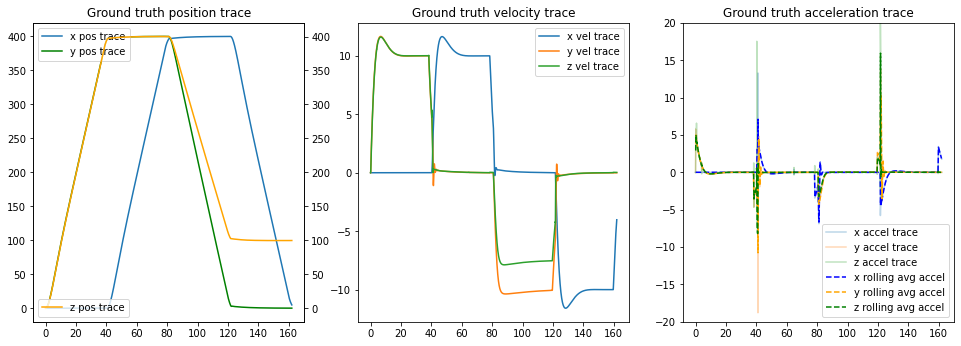

In [10]:
# Let's view ground truth position/velocity/accel

fig,axs = plt.subplots(ncols=3, figsize=(16.5,5.5))

axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 0), label='x pos trace')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 1), label='y pos trace', c='g')
axs2 = axs[0].twinx()
axs2.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 2), label='z pos trace', c='orange')
axs[0].legend(loc='upper left')
axs2.legend(loc='lower left')
axs[0].set_title('Ground truth position trace')


axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 0), label='x vel trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 1), label='y vel trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 2), label='z vel trace')
axs[1].legend()
axs[1].set_title('Ground truth velocity trace')

accel_df = pd.DataFrame({'Accel_x':extract_from_df(AC1_trajectory, 'accel', 0), 
                         'Accel_y':extract_from_df(AC1_trajectory, 'accel', 1), 
                         'Accel_z':extract_from_df(AC1_trajectory, 'accel', 2), 
                         'time':AC1_trajectory['time']})

axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel', 0), label='x accel trace', alpha=0.3)
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel', 1), label='y accel trace', alpha=0.3)
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel', 2), label='z accel trace', alpha=0.3)

axs[2].plot(accel_df['time'].rolling(30).mean(), accel_df['Accel_x'].rolling(30).mean(), linestyle='--', color='b',
            label='x rolling avg accel')
axs[2].plot(accel_df['time'].rolling(30).mean(), accel_df['Accel_y'].rolling(30).mean(), linestyle='--', color='orange', 
            label='y rolling avg accel')
axs[2].plot(accel_df['time'].rolling(30).mean(), accel_df['Accel_z'].rolling(30).mean(), linestyle='--', color='g', 
            label='z rolling avg accel')

axs[2].legend()
axs[2].set_title('Ground truth acceleration trace')

axs[2].set_ylim(-20,20)

plt.show()

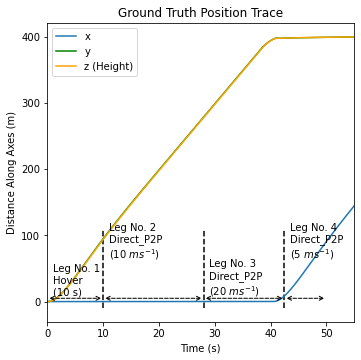

In [11]:
fig,axs = plt.subplots(figsize=(5.5,5.5))

axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 0), label='x')
axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 1), label='y', c='g')
axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 2), label='z (Height)', c='orange')
axs.vlines(10, -10, 110, linestyles='dashed', colors='k')
axs.vlines(28, -10, 110, linestyles='dashed', colors='k')
axs.vlines(42.5, -10, 110, linestyles='dashed', colors='k')
# axs.text(20, 20, r'$25$ s')
axs.set_title('Ground Truth Position Trace')
axs.set_ylabel('Distance Along Axes (m)')
axs.set_xlabel('Time (s)')
axs.set_xlim(0,55)
axs.legend()

axs.text(1, 10, 'Leg No. 1''\n''Hover''\n''(10 s)')
axs.text(11, 65, 'Leg No. 2''\n''Direct_P2P''\n'r'(10 $ms^{-1}$)')
axs.text(29, 10, 'Leg No. 3''\n''Direct_P2P''\n'r'(20 $ms^{-1}$)')
axs.text(43.5, 65, 'Leg No. 4''\n''Direct_P2P''\n'r'(5 $ms^{-1}$)')

plt.annotate(text='', xy=(10,5), xytext=(0,5), arrowprops=dict(arrowstyle='<->', ls='--'))
plt.annotate(text='', xy=(28,5), xytext=(10,5), arrowprops=dict(arrowstyle='<->', ls='--'))
plt.annotate(text='', xy=(42.5,5), xytext=(28,5), arrowprops=dict(arrowstyle='<->', ls='--'))
plt.annotate(text='', xy=(50,5), xytext=(42.5,5), arrowprops=dict(arrowstyle='<->', ls='--'))
plt.show()

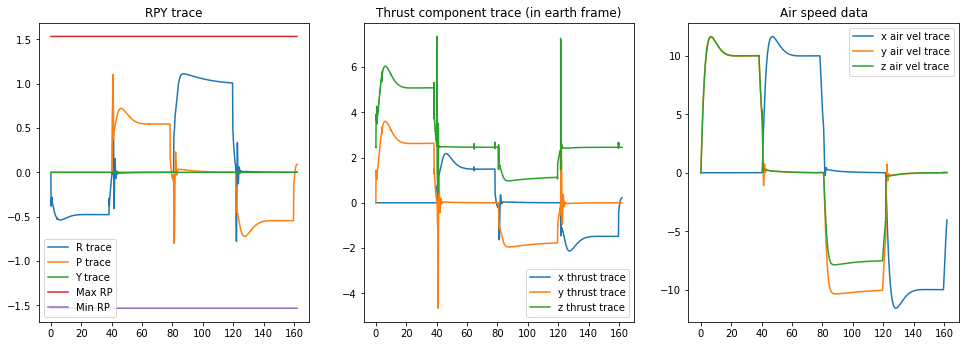

In [12]:
# Let's view ground RPY and Thrust

fig,axs = plt.subplots(ncols=3, figsize=(16.5,5.5))

axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'rpy', 0), label='R trace')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'rpy', 1), label='P trace')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'rpy', 2), label='Y trace')
max_rpy_array = np.empty(len(AC1_trajectory['time']))
max_rpy_array[:] = AC1_AircraftType.max_roll_pitch
axs[0].plot(AC1_trajectory['time'], max_rpy_array, label='Max RP')
axs[0].plot(AC1_trajectory['time'], -max_rpy_array, label='Min RP')
axs[0].legend()
axs[0].set_title('RPY trace')


axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'thrust', 0), label='x thrust trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'thrust', 1), label='y thrust trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'thrust', 2), label='z thrust trace')
axs[1].legend()
axs[1].set_title('Thrust component trace (in earth frame)')

axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'air_vel', 0), label='x air vel trace')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'air_vel', 1), label='y air vel trace')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'air_vel', 2), label='z air vel trace')
axs[2].legend()
axs[2].set_title('Air speed data')


plt.show()

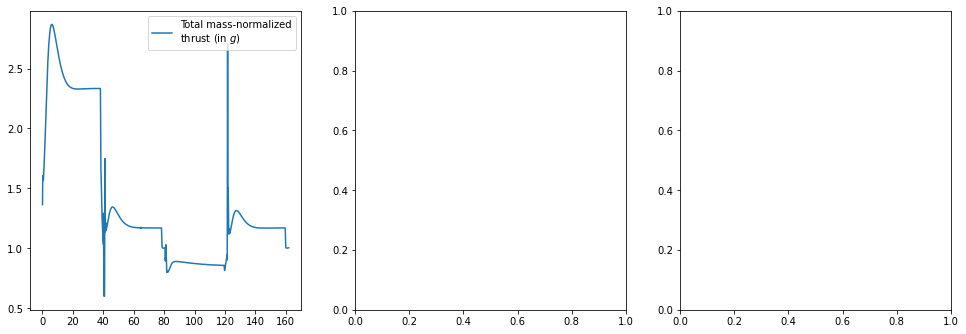

In [13]:
fig, axs = plt.subplots(ncols=3, figsize=(16.5,5.5))

thrust_df = pd.DataFrame({'time':AC1_trajectory['time'], 
                          'thrust_x':extract_from_df(AC1_trajectory, 'thrust', 0),
                          'thrust_y':extract_from_df(AC1_trajectory, 'thrust', 1),
                          'thrust_z':extract_from_df(AC1_trajectory, 'thrust', 2)
                         })

thrust_df['Thrust Produced'] = np.sqrt(thrust_df['thrust_x']**2 + thrust_df['thrust_y']**2 + thrust_df['thrust_z']**2)

axs[0].plot(thrust_df['time'].rolling(30).mean(), 
            (1/AC1_AircraftType.mass) * (1/9.81) * thrust_df['Thrust Produced'].rolling(30).mean(), 
            label=r'Total mass-normalized''\n''thrust (in $g$)')

axs[0].legend()

plt.show()

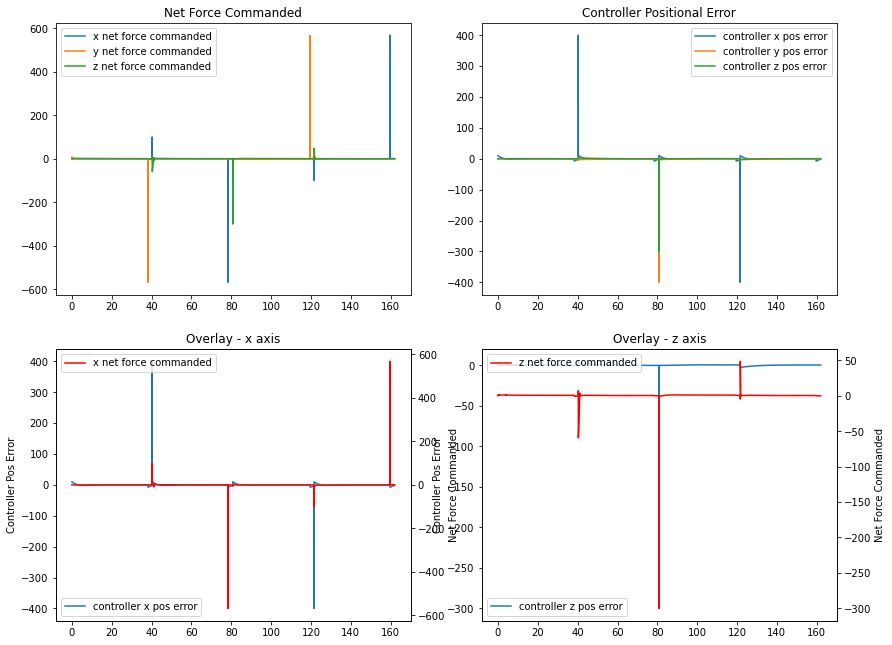

In [14]:
# Let's view ground truth controller error and commanded net force

fig,axs = plt.subplots(ncols=2, nrows=2, figsize=(14,11))

axs[0,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 0), label='x net force commanded')
axs[0,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 1), label='y net force commanded')
axs[0,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 2), label='z net force commanded')
axs[0,0].legend()
axs[0,0].set_title('Net Force Commanded')


axs[0,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 0), label='controller x pos error')
axs[0,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 1), label='controller y pos error')
axs[0,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 2), label='controller z pos error')
axs[0,1].legend()
axs[0,1].set_title('Controller Positional Error')

axs[1,0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 0), label='controller x pos error')
axs[1,0].legend(loc = 'lower left')
axs[1,0].set_ylabel('Controller Pos Error')
axs2 = axs[1,0].twinx()
axs2.set_ylabel('Net Force Commanded')
axs2.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 0), label='x net force commanded', color='r')
axs2.legend()
axs[1,0].set_title('Overlay - x axis')

axs[1,1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 2), label='controller z pos error')
axs[1,1].set_ylabel('Controller Pos Error')
axs[1,1].legend(loc = 'lower left')
axs3 = axs[1,1].twinx()
axs3.set_ylabel('Net Force Commanded')
axs3.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'commanded_net_force', 2), label='z net force commanded', color='r')
axs3.legend()
axs[1,1].set_title('Overlay - z axis')


plt.show()

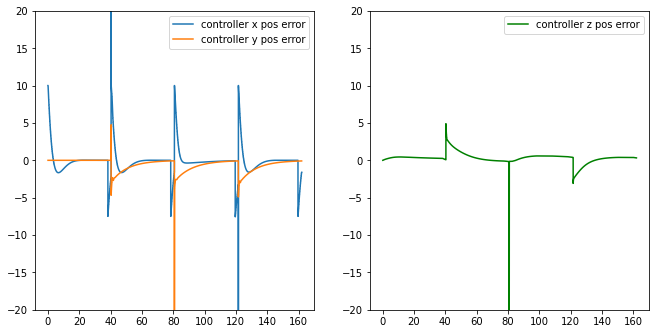

In [15]:
fig,axs = plt.subplots(ncols=2, figsize=(11,5.5))

axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 0), label='controller x pos error')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 1), label='controller y pos error')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 2), label='controller z pos error', 
           color='g')

axs[0].set_ylim(-20,20)
axs[1].set_ylim(-20,20)


axs[0].legend()
axs[1].legend()

plt.show()

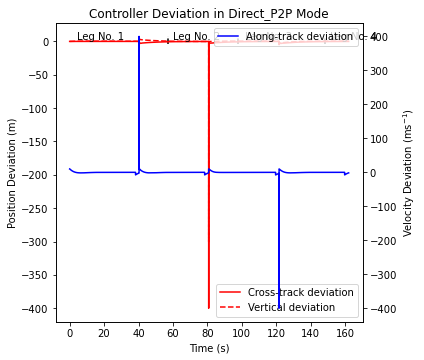

In [16]:
fig, ax = plt.subplots(figsize=(5.5,5.5))

ax2 = ax.twinx()
ax2.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 0), 
         label='Along-track deviation', color='b')
ax2.legend(loc='upper right')
ax2.set_ylabel(r'Velocity Deviation (ms$^{-1}$)')

ax.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 1), 
        label='Cross-track deviation', color='red')
ax.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'controller_pos_err', 2), 
        label='Vertical deviation', color='red', linestyle='--')
ax.legend(loc='lower right')
ax.set_title('Controller Deviation in Direct_P2P Mode')
ax.set_ylabel(r'Position Deviation (m)')

ax.set_xlabel(r'Time (s)')


ax.vlines(57, -3.5, 7.5, linestyles='dashed', colors='k')
ax.vlines(98, -3.5, 7.5, linestyles='dashed', colors='k')
ax.vlines(148, -3.5, 7.5, linestyles='dashed', colors='k')

ax.text(4, 3, 'Leg No. 1')
ax.text(60, 3, 'Leg No. 2')
ax.text(102, 3, 'Leg No. 3')
ax.text(151, 3, 'Leg No. 4')

plt.show()

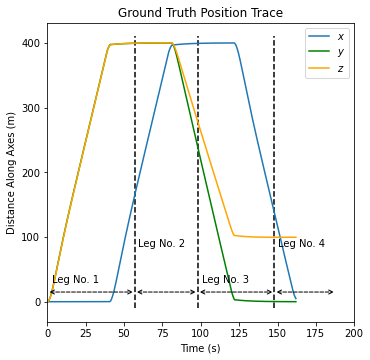

In [17]:
fig,axs = plt.subplots(figsize=(5.5,5.5))

axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 0), label=r'$x$')
axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 1), label=r'$y$', c='g')
axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 2), label=r'$z$', c='orange')
axs.vlines(57, -10, 410, linestyles='dashed', colors='k')
axs.vlines(98, -10, 410, linestyles='dashed', colors='k')
axs.vlines(148, -10, 410, linestyles='dashed', colors='k')
# axs.text(20, 20, r'$25$ s')
axs.set_title('Ground Truth Position Trace')
axs.set_ylabel('Distance Along Axes (m)')
axs.set_xlabel('Time (s)')
axs.set_xlim(0,200)
axs.legend()

# axs.text(3, 30, 'Leg No. 1''\n''Direct_P2P')
# axs.text(59, 85, 'Leg No. 2''\n''Direct_P2P')
# axs.text(101, 30, 'Leg No. 3''\n''Direct_P2P')
# axs.text(150, 85, 'Leg No. 4''\n''Direct_P2P')

axs.text(3, 30, 'Leg No. 1')
axs.text(59, 85, 'Leg No. 2')
axs.text(101, 30, 'Leg No. 3')
axs.text(150, 85, 'Leg No. 4')

plt.annotate(text='', xy=(57,15), xytext=(0,15), arrowprops=dict(arrowstyle='<->', ls='--'))
plt.annotate(text='', xy=(98,15), xytext=(57,15), arrowprops=dict(arrowstyle='<->', ls='--'))
plt.annotate(text='', xy=(148,15), xytext=(98,15), arrowprops=dict(arrowstyle='<->', ls='--'))
plt.annotate(text='', xy=(188,15), xytext=(148,15), arrowprops=dict(arrowstyle='<->', ls='--'))
plt.show()

In [18]:
AC1_FlightPlan.plan.iloc[0]['Starting Wpt']

array([0, 0, 0])

NSE hor radial error std: 0.000
 x std: 0.000, y std: 0.000, z std: 0.000


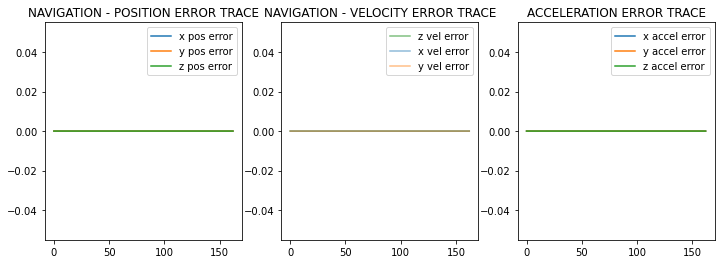

In [19]:
# Let's view NAVIGATIONAL ERRORS for position/velocity/accel

fig,axs = plt.subplots(ncols=3, figsize=(12,4))

axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos_err', 0), label='x pos error')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos_err', 1), label='y pos error')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos_err', 2), label='z pos error')
axs[0].legend()
axs[0].set_title('NAVIGATION - POSITION ERROR TRACE')
# axs[0].set_xlim(0,1)

axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel_err', 2), label='z vel error', 
            alpha=0.5, color='g')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel_err', 0), label='x vel error', 
            alpha=0.5)
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel_err', 1), label='y vel error', 
            alpha=0.5)
axs[1].legend()
axs[1].set_title('NAVIGATION - VELOCITY ERROR TRACE')

axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel_err', 0), label='x accel error')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel_err', 1), label='y accel error')
axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'accel_err', 2), label='z accel error')
axs[2].legend()
axs[2].set_title('ACCELERATION ERROR TRACE')

print('NSE hor radial error std: %.3f'%(AC1_trajectory['gt_hor_err'].std()) + 
      '\n x std: %.3f, y std: %.3f, z std: %.3f'%((extract_from_df(AC1_trajectory, 'gt_pos_err', 0).std(), 
                                                   extract_from_df(AC1_trajectory, 'gt_pos_err', 1).std(), 
                                                   extract_from_df(AC1_trajectory, 'gt_pos_err', 2).std())))

plt.show()

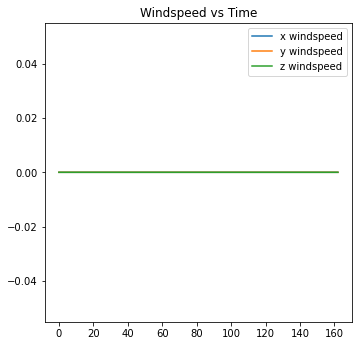

In [20]:
# Let's view WIND SPEED

fig,axs = plt.subplots(ncols=1, figsize=(5.5,5.5))

axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'wind_spd', 0), label='x windspeed')
axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'wind_spd', 1), label='y windspeed')
axs.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'wind_spd', 2), label='z windspeed')
axs.legend()
axs.set_title('Windspeed vs Time')
#axs.set_xlim(0,20)

plt.show()

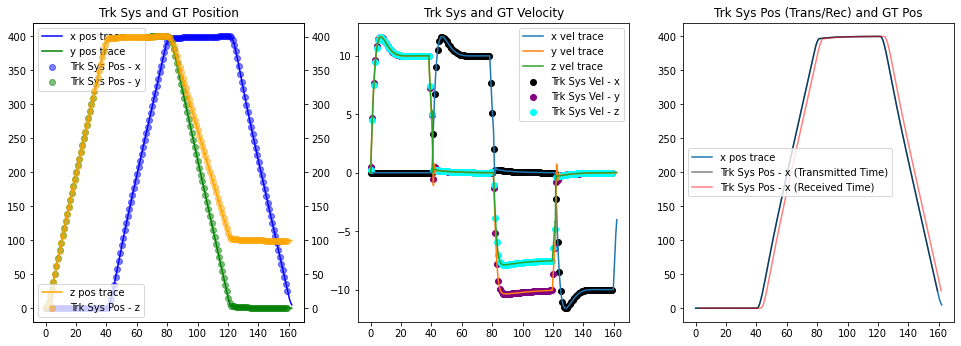

In [21]:
def special_concat(trajectory):
    return np.concatenate(trajectory).reshape(len(trajectory), 8) # 8 is the length of each mini array

AC1_Trk_Trajectory = special_concat(Trackinator.trajectories['AC1'].trajectory)
AC1_Trk_trans_time = AC1_Trk_Trajectory[:,0]
AC1_Trk_rec_time = AC1_Trk_Trajectory[:,1]
AC1_Trk_est_pos = AC1_Trk_Trajectory[:,2:5]
AC1_Trk_est_vel = AC1_Trk_Trajectory[:,5:8]

# Compare reported position and velocities (trk system) vs ground truth
fig, axs = plt.subplots(ncols=3, figsize=(16.5,5.5))

axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 0), label='x pos trace', c='blue')
axs[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 1), label='y pos trace', c='g')
axs[0].scatter(AC1_Trk_trans_time, AC1_Trk_est_pos[:,0], c='blue', label='Trk Sys Pos - x', alpha=0.5)
axs[0].scatter(AC1_Trk_trans_time, AC1_Trk_est_pos[:,1], c='g', label='Trk Sys Pos - y', alpha=0.5)
axs2 = axs[0].twinx()
axs2.plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 2), label='z pos trace', c='orange')
axs2.scatter(AC1_Trk_trans_time, AC1_Trk_est_pos[:,2], c='orange', label='Trk Sys Pos - z', alpha=0.5)



axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 0), label='x vel trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 1), label='y vel trace')
axs[1].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 2), label='z vel trace')
axs[1].scatter(AC1_Trk_trans_time, AC1_Trk_est_vel[:,0], c='black', label='Trk Sys Vel - x')
axs[1].scatter(AC1_Trk_trans_time, AC1_Trk_est_vel[:,1], c='purple', label='Trk Sys Vel - y')
axs[1].scatter(AC1_Trk_trans_time, AC1_Trk_est_vel[:,2], c='cyan', label='Trk Sys Vel - z')



axs[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_pos', 0), label='x pos trace')
axs[2].plot(AC1_Trk_trans_time, AC1_Trk_est_pos[:,0], c='black', label='Trk Sys Pos - x (Transmitted Time)', alpha=0.5)
axs[2].plot(AC1_Trk_rec_time, AC1_Trk_est_pos[:,0], c='r', label='Trk Sys Pos - x (Received Time)', alpha=0.5)

axs[0].legend(loc='upper left')
axs2.legend(loc='lower left')
axs[0].set_title('Trk Sys and GT Position')
axs[1].legend()
axs[1].set_title('Trk Sys and GT Velocity')
axs[2].legend()
axs[2].set_title('Trk Sys Pos (Trans/Rec) and GT Pos')


def axs_set_xlim(xlim):
    axs[0].set_xlim(0, xlim)
    axs[1].set_xlim(0, xlim)
    axs[2].set_xlim(0, xlim)
    
def axs_set_ylim(ylim):
    axs[1].set_ylim(-ylim, ylim)

# axs_set_xlim(700)
# axs_set_ylim(20)
    
plt.show()

In [22]:
# # For spline mode testing
# fig, ax = plt.subplots(ncols=2, figsize=(11,5.5))

# ax[0].scatter(AC1_Controller.spl_times, AC1_Controller.spl_params)
# ax[0].set_title('Spline Param vs Time')
# ax[0].set_ylabel(r'Spline Param ($\sigma$)')
# ax[0].set_xlabel('Time')

# grd_spd = np.sqrt(extract_from_df(AC1_trajectory, 'gt_vel', 0)**2 + extract_from_df(AC1_trajectory, 'gt_vel', 1)**2)

# ax[1].plot(AC1_trajectory['time'], grd_spd)
# ax[1].set_title('Grd Spd vs Time')
# ax[1].set_ylabel(r'Grd Spd (ms$^{-1}$)')
# ax[1].set_xlabel('Time')

# # ax[1].set_ylim(-1,30)

# plt.show()

In [23]:
# AC1_Controller.tangential_unit_vector_planar

In [24]:
180*0.8/np.pi

45.83662361046586

[0 0 0]


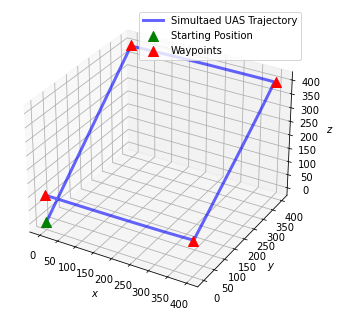

In [25]:
# %matplotlib notebook

fig = plt.figure(figsize=(5.5,5.5))
ax = fig.add_subplot(projection='3d')

ax.plot(extract_from_df(AC1_trajectory, 'gt_pos', 0), 
        extract_from_df(AC1_trajectory, 'gt_pos', 1), 
        extract_from_df(AC1_trajectory, 'gt_pos', 2), 
        c='b', alpha=0.6, label='Simultaed UAS Trajectory', 
        linewidth=3)

xx, yy, zz = AC1_FlightPlan.plan.iloc[0]['Starting Wpt']
ax.scatter(xx, yy, zz, c='g', marker='^', s=100, label='Starting Position')
print(AC1_FlightPlan.plan.iloc[0]['Starting Wpt'])

# for wpt in AC1_FlightPlan.plan['Ending Wpt']:
#     xx, yy, zz = wpt
#     ax.scatter(xx, yy, zz, c='r', marker='^', s=300, label='Waypoints')
#     print(wpt)

if 0 in list(AC1_FlightPlan.plan['Spline Number'].unique()):
    spl_nums = list(AC1_FlightPlan.plan['Spline Number'].unique())
    if 'NA' in list(AC1_FlightPlan.plan['Spline Number'].unique()):
        spl_nums.remove('NA')
    for func, summary, spl_num in zip(AC1_FlightPlan.spl_df['Spline Func'], 
                                      AC1_FlightPlan.spl_df['Spline Summary'], 
                                      spl_nums):
        zs = AC1_FlightPlan.plan[AC1_FlightPlan.plan['Spline Number']==spl_num].iloc[0]['Ending Wpt'][2]
        ds = summary['ds_target_res']
        spl_params = np.arange(0, 1 + ds, ds)
        xc, yc, zc = interpolate.splev(spl_params, func)
        ax.plot(xc, yc, zc, linestyle='--', color='k', label='Ideal Path')

xl = []
yl = []
zl = []
for wpt in AC1_FlightPlan.plan['Ending Wpt']:
    xx, yy, zz = wpt
    xl.append(xx)
    yl.append(yy)
    zl.append(zz)
    
ax.scatter(xl, yl, zl, c='r', marker='^', s=100, label='Waypoints', depthshade=False)

    
# ax.set_xlim(-300, 300)
# ax.set_xlim(-10, 510)
# ax.set_ylim(-100, 100)
# ax.set_ylim(-300, 300)
# ax.set_zlim(-50,50)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')

ax.legend(loc='upper right')

plt.show()

In [26]:
AC1_FlightPlan.plan

,Leg No.,Target Speed,Mode,Starting Wpt,EDT,Ending Wpt,ETA,Duration,Climb Rate,Spline Number,Est. End. Sigma
0,1,10,Direct_P2P,"[0, 0, 0]",0,"[0, 400, 400]",40,40,0,NA,NaN
1,2,10,Direct_P2P,"[0, 400, 400]",40,"[400, 400, 400]",80,40,0,NA,NaN
2,3,10,Direct_P2P,"[400, 400, 400]",80,"[400, 0, 100]",120,40,0,NA,NaN
3,4,10,Direct_P2P,"[400, 0, 100]",120,"[0, 0, 100]",160,40,0,NA,NaN


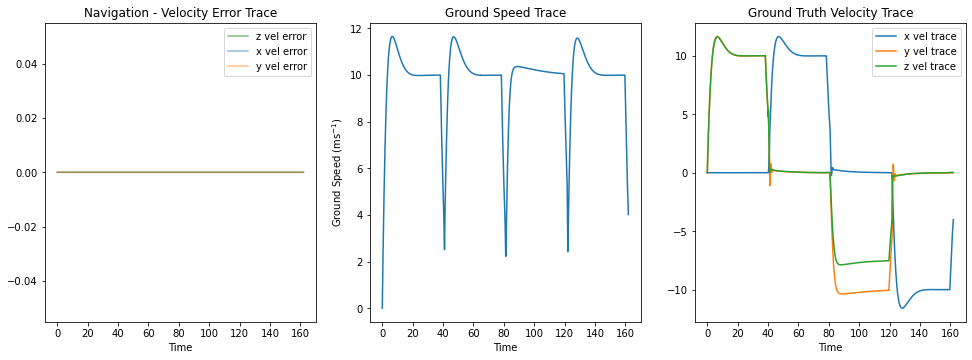

In [27]:
fig, ax = plt.subplots(ncols=3, figsize=(16.5,5.5))

ax[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel_err', 2), label='z vel error', 
            alpha=0.5, color='g')
ax[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel_err', 0), label='x vel error', 
            alpha=0.5)
ax[0].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel_err', 1), label='y vel error', 
            alpha=0.5)
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_title('Navigation - Velocity Error Trace')

grd_spd = np.sqrt(extract_from_df(AC1_trajectory, 'gt_vel', 0)**2 + extract_from_df(AC1_trajectory, 'gt_vel', 1)**2)

ax[1].plot(AC1_trajectory['time'], grd_spd)
ax[1].set_title('Ground Speed Trace')
ax[1].set_ylabel(r'Ground Speed (ms$^{-1}$)')
ax[1].set_xlabel('Time')

ax[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 0), label='x vel trace')
ax[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 1), label='y vel trace')
ax[2].plot(AC1_trajectory['time'], extract_from_df(AC1_trajectory, 'gt_vel', 2), label='z vel trace')
ax[2].legend()
ax[2].set_xlabel('Time')
ax[2].set_title('Ground Truth Velocity Trace')

plt.show()

In [28]:
max(np.nan, 0)

nan

In [29]:
(30/60) / AC1_FlightPlan.current_leg.spl_path_len 

AttributeError: 'NoneType' object has no attribute 'spl_path_len'

In [ ]:
np.max(AC1_Controller.spl_params)

In [ ]:
1 - (30/60) / AC1_FlightPlan.current_leg.spl_path_len 

In [ ]:
1- AC1_FlightPlan.current_leg.spl_ds 

In [ ]:
AC1_Controller.spl_param_counter

In [ ]:
AC1_Controller.spl_params[-10:]

In [ ]:
abs(AC1_Controller.spl_params[-2] - AC1_Controller.spl_params[-1])/AC1_FlightPlan.current_leg.spl_ds 